## **Health Insurance Premium Prediction Younger Adult Less Than 25**

**Problem Understanding**
  
The rising complexity of medical expenses has made it increasingly difficult for insurance companies to determine fair and accurate premium pricing.
To address this challenge, this project aims to develop a predictive machine learning model capable of estimating health insurance premiums based on individual health and lifestyle factors such as age, BMI, smoking habits, and medical history.

**Objective:**
  
- Develop a high-accuracy (>97%) predictive model. The percentage difference between 
  the predicted and actual value on a minimum of 95% of the errors should be less than 
  10%. 
- Deploy the model in the cloud so that an insurance underwriter can run it from anywhere. 
- Create an interactive Streamlit application that an underwriter can use for predictions. 

In [222]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, train_test_split
import warnings
warnings.filterwarnings("ignore")


<h2 align="center" style="color:blue; font-weight:bold; font-size:30px;">Data Loading</h2>


In [223]:
df = pd.read_excel("premiums_young.xlsx")
df.head(3)

,Age,Gender,Region,Marital_status,Number Of Dependants,BMI_Category,Smoking_Status,Employment_Status,Income_Level,Income_Lakhs,Medical History,Insurance_Plan,Annual_Premium_Amount
0,18,Male,Northeast,Unmarried,0,Overweight,Regular,Self-Employed,> 40L,99,High blood pressure,Silver,13365
1,22,Female,Northwest,Unmarried,0,Underweight,No Smoking,Freelancer,<10L,3,No Disease,Silver,11050
2,21,Female,Southeast,Unmarried,0,Normal,Regular,Salaried,> 40L,97,No Disease,Silver,11857


In [224]:
df.shape

(20096, 13)

In [225]:
df.columns = df.columns.str.replace(" ","_").str.lower()
df.head(3)

,age,gender,region,marital_status,number_of_dependants,bmi_category,smoking_status,employment_status,income_level,income_lakhs,medical_history,insurance_plan,annual_premium_amount
0,18,Male,Northeast,Unmarried,0,Overweight,Regular,Self-Employed,> 40L,99,High blood pressure,Silver,13365
1,22,Female,Northwest,Unmarried,0,Underweight,No Smoking,Freelancer,<10L,3,No Disease,Silver,11050
2,21,Female,Southeast,Unmarried,0,Normal,Regular,Salaried,> 40L,97,No Disease,Silver,11857


<h2 align="center" style="color:blue; font-size:30px; font-weight:bold;">Exploratory Data Analysis & Data Cleaning</h2>


## **Handle Missing Values**

In [226]:
df.isna().sum()

age                      0
gender                   0
region                   0
marital_status           0
number_of_dependants     0
bmi_category             0
smoking_status           2
employment_status        1
income_level             4
income_lakhs             0
medical_history          0
insurance_plan           0
annual_premium_amount    0
dtype: int64

In [227]:
df.dropna(inplace=True)
df.isna().sum()

age                      0
gender                   0
region                   0
marital_status           0
number_of_dependants     0
bmi_category             0
smoking_status           0
employment_status        0
income_level             0
income_lakhs             0
medical_history          0
insurance_plan           0
annual_premium_amount    0
dtype: int64

## **Handle Duplicates**

In [228]:
df.duplicated().sum()

np.int64(0)

In [229]:
df.drop_duplicates(inplace=True)
df.duplicated().sum()

np.int64(0)

In [230]:
df.describe()

,age,number_of_dependants,income_lakhs,annual_premium_amount
count,20090.000000,20090.000000,20090.000000,20090.000000
mean,21.494375,0.718019,22.510851,8142.096267
std,2.294052,0.940713,23.420493,2749.906347
min,18.000000,-3.000000,1.000000,3501.000000
25%,19.000000,0.000000,6.000000,6022.250000
50%,22.000000,0.000000,16.000000,7939.000000
75%,23.000000,1.000000,31.000000,9561.000000
max,25.000000,3.000000,790.000000,18186.000000


## **Data Cleaning: number_of_dependants**

In [231]:
df[df['number_of_dependants']<0]['number_of_dependants'].unique()

array([-3, -1])

**I observed some negative values in number_of_dependants. To address this, I replaced them with their absolute values to ensure all entries were positive.**

In [232]:
df['number_of_dependants'] = df['number_of_dependants'].abs()

df.describe()

,age,number_of_dependants,income_lakhs,annual_premium_amount
count,20090.000000,20090.000000,20090.000000,20090.000000
mean,21.494375,0.722598,22.510851,8142.096267
std,2.294052,0.937200,23.420493,2749.906347
min,18.000000,0.000000,1.000000,3501.000000
25%,19.000000,0.000000,6.000000,6022.250000
50%,22.000000,0.000000,16.000000,7939.000000
75%,23.000000,1.000000,31.000000,9561.000000
max,25.000000,3.000000,790.000000,18186.000000


## **1. Numeric Columns**

#####  **Univariate Analysis: Numeric Columns**

###### **Box plots for numeric columns**

In [233]:
numeric_columns = df.select_dtypes(include=['float64', 'int64']).columns
numeric_columns  

Index(['age', 'number_of_dependants', 'income_lakhs', 'annual_premium_amount'], dtype='object')

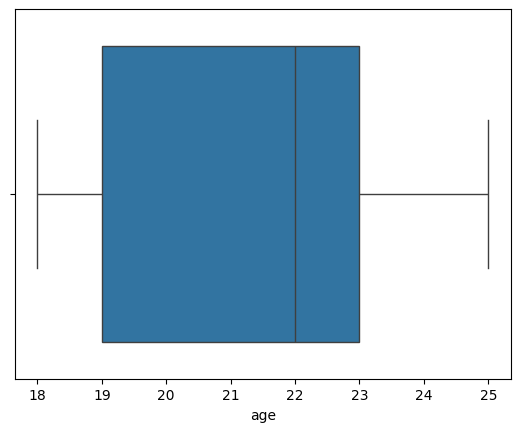

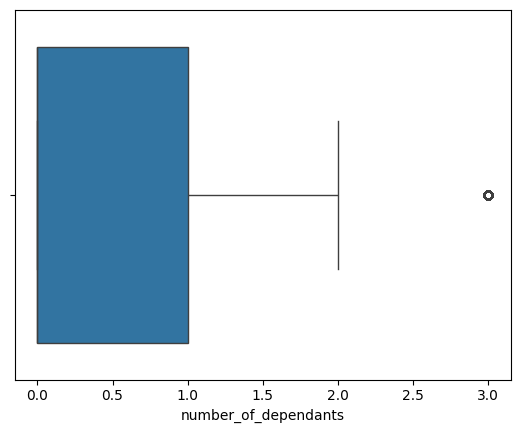

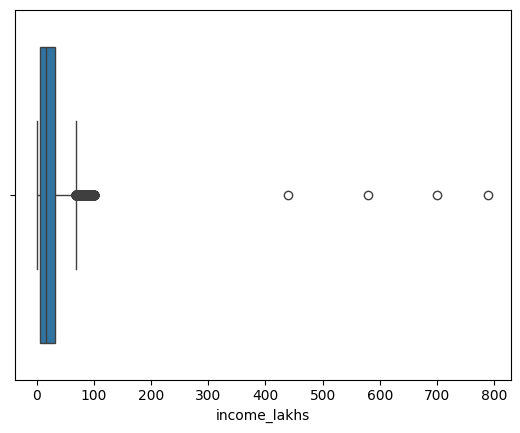

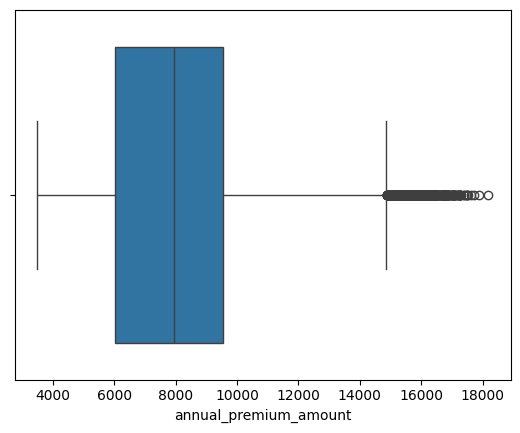

In [234]:
for col in numeric_columns:
    sns.boxplot(x=df[col])
    plt.show()

## **Outlier Treatment: Age Column**

In [235]:
df[df['age']>100]['age'].unique()

array([], dtype=int64)

In [236]:
df1 = df[df.age<=100]
df1.age.describe()

count    20090.000000
mean        21.494375
std          2.294052
min         18.000000
25%         19.000000
50%         22.000000
75%         23.000000
max         25.000000
Name: age, dtype: float64

## **Outlier Treatment: Income Column**

In [237]:
def get_iqr_bounds(col):
    Q1, Q3 = col.quantile([0.25, 0.75])
    IQR = Q3-Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return lower_bound, upper_bound

lower, upper = get_iqr_bounds(df1['income_lakhs'])
lower, upper

(-31.5, 68.5)

In [238]:
df1[df1.income_lakhs>upper].shape

(1295, 13)

**There were many legitimate records that would have been removed if I had used the IQR bounds method. so, I decided to use a simple quantile bound instead.**

In [239]:
quantile_thresold = df1.income_lakhs.quantile(0.999)
quantile_thresold

np.float64(100.0)

In [240]:
df1[df1.income_lakhs>quantile_thresold].shape

(4, 13)

In [241]:
df2 = df1[df1.income_lakhs<=quantile_thresold].copy()
df2.shape

(20086, 13)

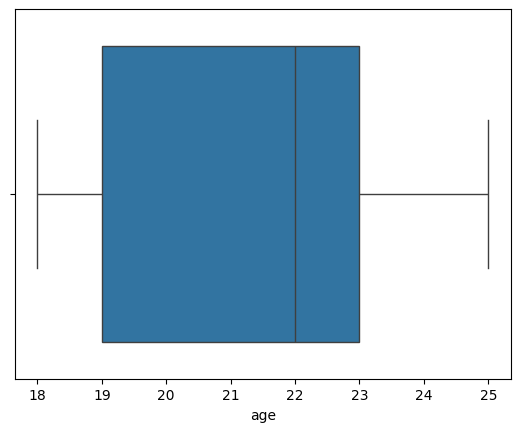

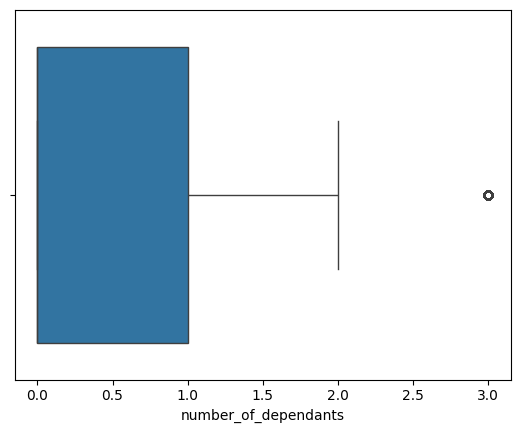

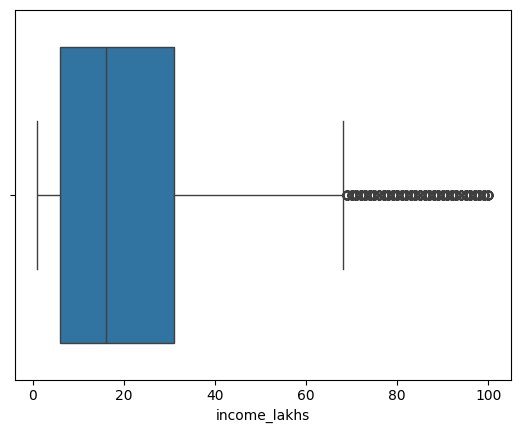

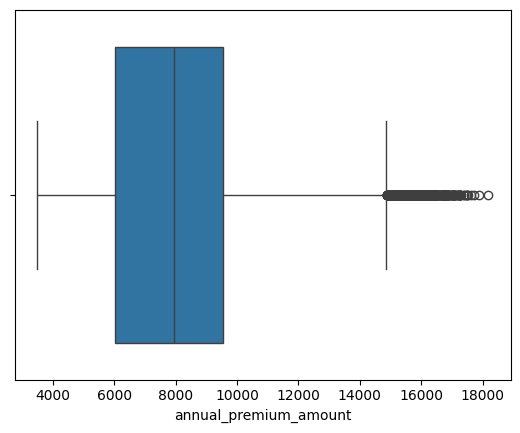

In [242]:
for col in numeric_columns:
    sns.boxplot(x=df2[col])
    plt.show()

### **Data Visualization**

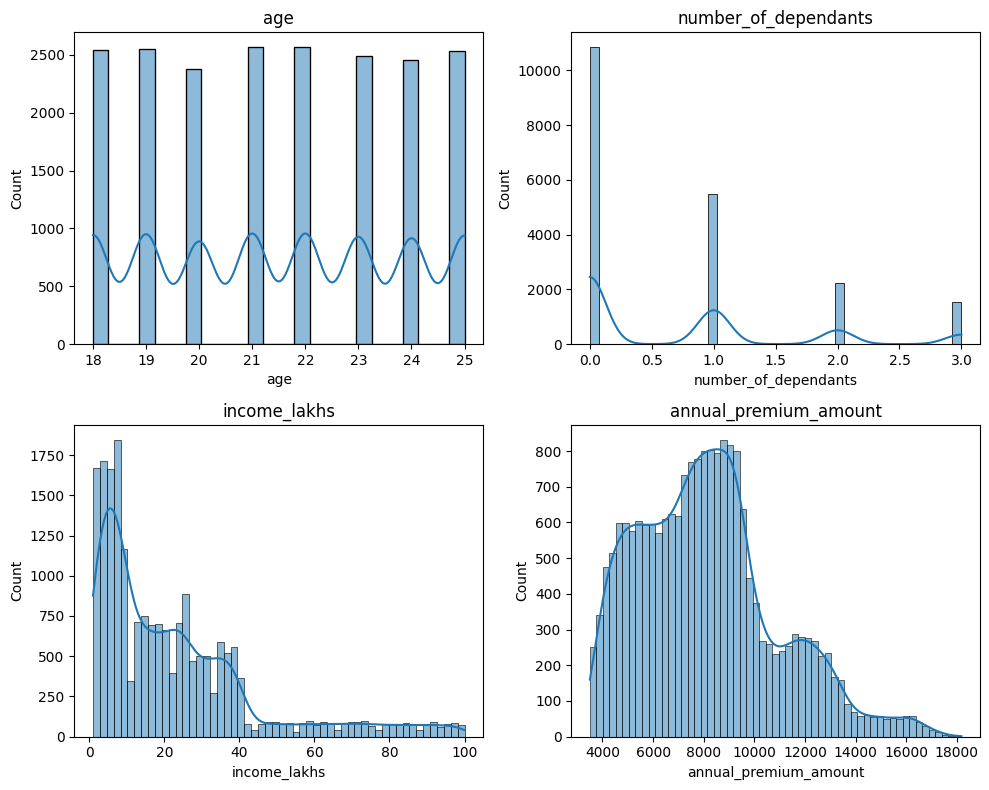

In [243]:
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(10, 8))  # Adjust the size as necessary

for i, column in enumerate(numeric_columns):
    ax = axs[i//2, i%2]  # Determines the position of the subplot in the grid
    sns.histplot(df2[column], kde=True, ax=ax)
    ax.set_title(column)

plt.tight_layout()
plt.show()

In [244]:
df2.head(2)

,age,gender,region,marital_status,number_of_dependants,bmi_category,smoking_status,employment_status,income_level,income_lakhs,medical_history,insurance_plan,annual_premium_amount
0,18,Male,Northeast,Unmarried,0,Overweight,Regular,Self-Employed,> 40L,99,High blood pressure,Silver,13365
1,22,Female,Northwest,Unmarried,0,Underweight,No Smoking,Freelancer,<10L,3,No Disease,Silver,11050


## **Bivariate Analysis: Numeric Columns**

In [245]:
numeric_columns

Index(['age', 'number_of_dependants', 'income_lakhs', 'annual_premium_amount'], dtype='object')

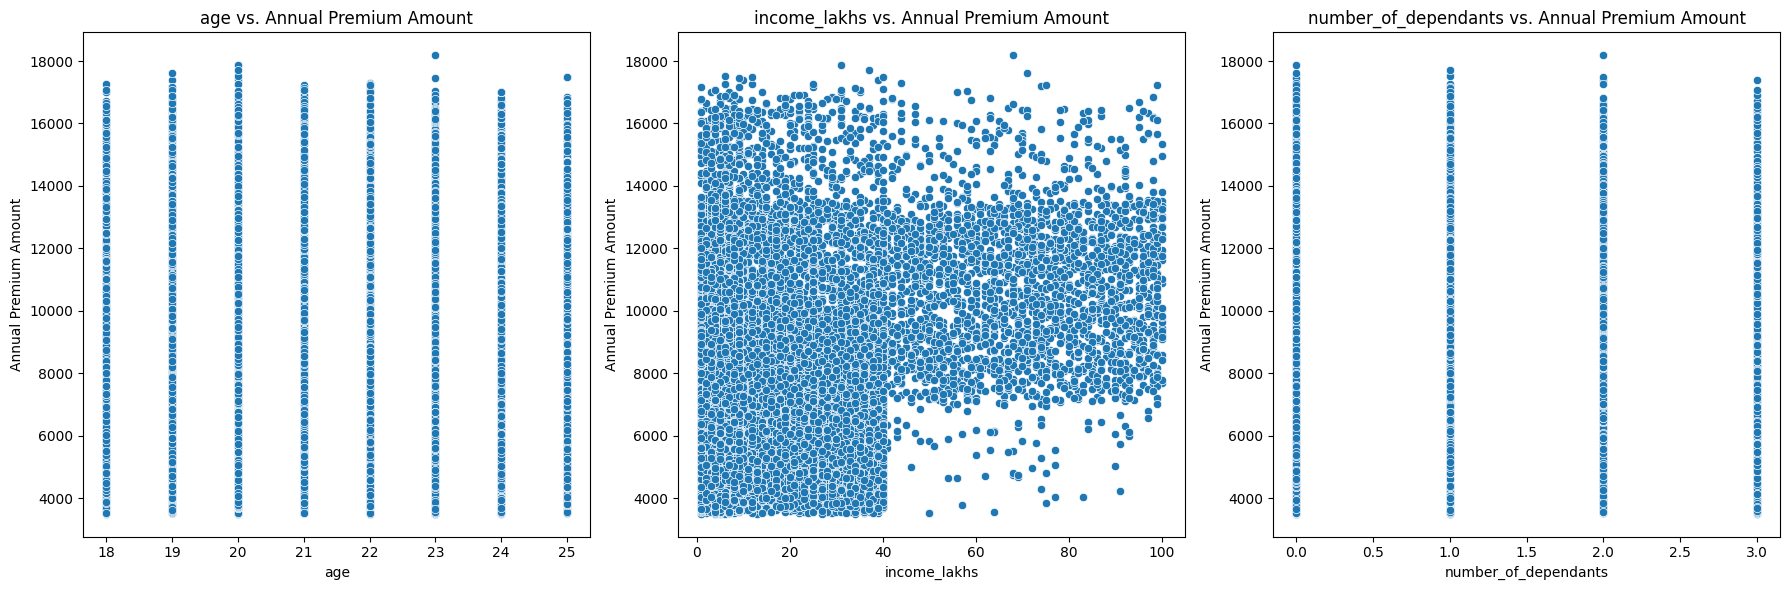

In [246]:
numeric_features = ['age', 'income_lakhs', 'number_of_dependants']

fig, axes = plt.subplots(1, len(numeric_features), figsize=(18, 6))  # Adjust figure size as necessary

for ax, column in zip(axes, numeric_features):
    sns.scatterplot(x=df2[column], y=df2['annual_premium_amount'], ax=ax)
    ax.set_title(f'{column} vs. Annual Premium Amount')
    ax.set_xlabel(column)
    ax.set_ylabel('Annual Premium Amount')

plt.tight_layout()  # Adjust layout
plt.show()

## **2. Categorical Columns**

In [247]:
categorical_cols = ['gender', 'region', 'marital_status', 'bmi_category', 'smoking_status', 'employment_status', 'income_level', 'medical_history', 'insurance_plan']
for col in categorical_cols:
    print(col, ":", df2[col].unique())

gender : ['Male' 'Female']
region : ['Northeast' 'Northwest' 'Southeast' 'Southwest']
marital_status : ['Unmarried' 'Married']
bmi_category : ['Overweight' 'Underweight' 'Normal' 'Obesity']
smoking_status : ['Regular' 'No Smoking' 'Occasional' 'Smoking=0' 'Does Not Smoke'
 'Not Smoking']
employment_status : ['Self-Employed' 'Freelancer' 'Salaried']
income_level : ['> 40L' '<10L' '10L - 25L' '25L - 40L']
medical_history : ['High blood pressure' 'No Disease' 'Diabetes & High blood pressure'
 'Diabetes & Heart disease' 'Diabetes' 'Diabetes & Thyroid'
 'Heart disease' 'Thyroid' 'High blood pressure & Heart disease']
insurance_plan : ['Silver' 'Bronze' 'Gold']


In [248]:
df2['smoking_status'].replace({
    'Not Smoking': 'No Smoking',
    'Does Not Smoke': 'No Smoking',
    'Smoking=0': 'No Smoking'
}, inplace=True)

df2['smoking_status'].unique()

array(['Regular', 'No Smoking', 'Occasional'], dtype=object)

## **Univariate Analysis**

In [249]:
df2.head(2)

,age,gender,region,marital_status,number_of_dependants,bmi_category,smoking_status,employment_status,income_level,income_lakhs,medical_history,insurance_plan,annual_premium_amount
0,18,Male,Northeast,Unmarried,0,Overweight,Regular,Self-Employed,> 40L,99,High blood pressure,Silver,13365
1,22,Female,Northwest,Unmarried,0,Underweight,No Smoking,Freelancer,<10L,3,No Disease,Silver,11050


In [250]:
pct_count = df2['gender'].value_counts(normalize=True)*100
pct_count

gender
Male      55.038335
Female    44.961665
Name: proportion, dtype: float64

<Axes: xlabel='gender'>

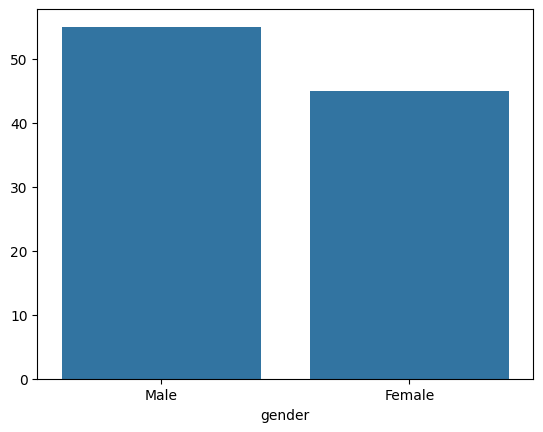

In [251]:
sns.barplot(x=pct_count.index, y=pct_count.values)

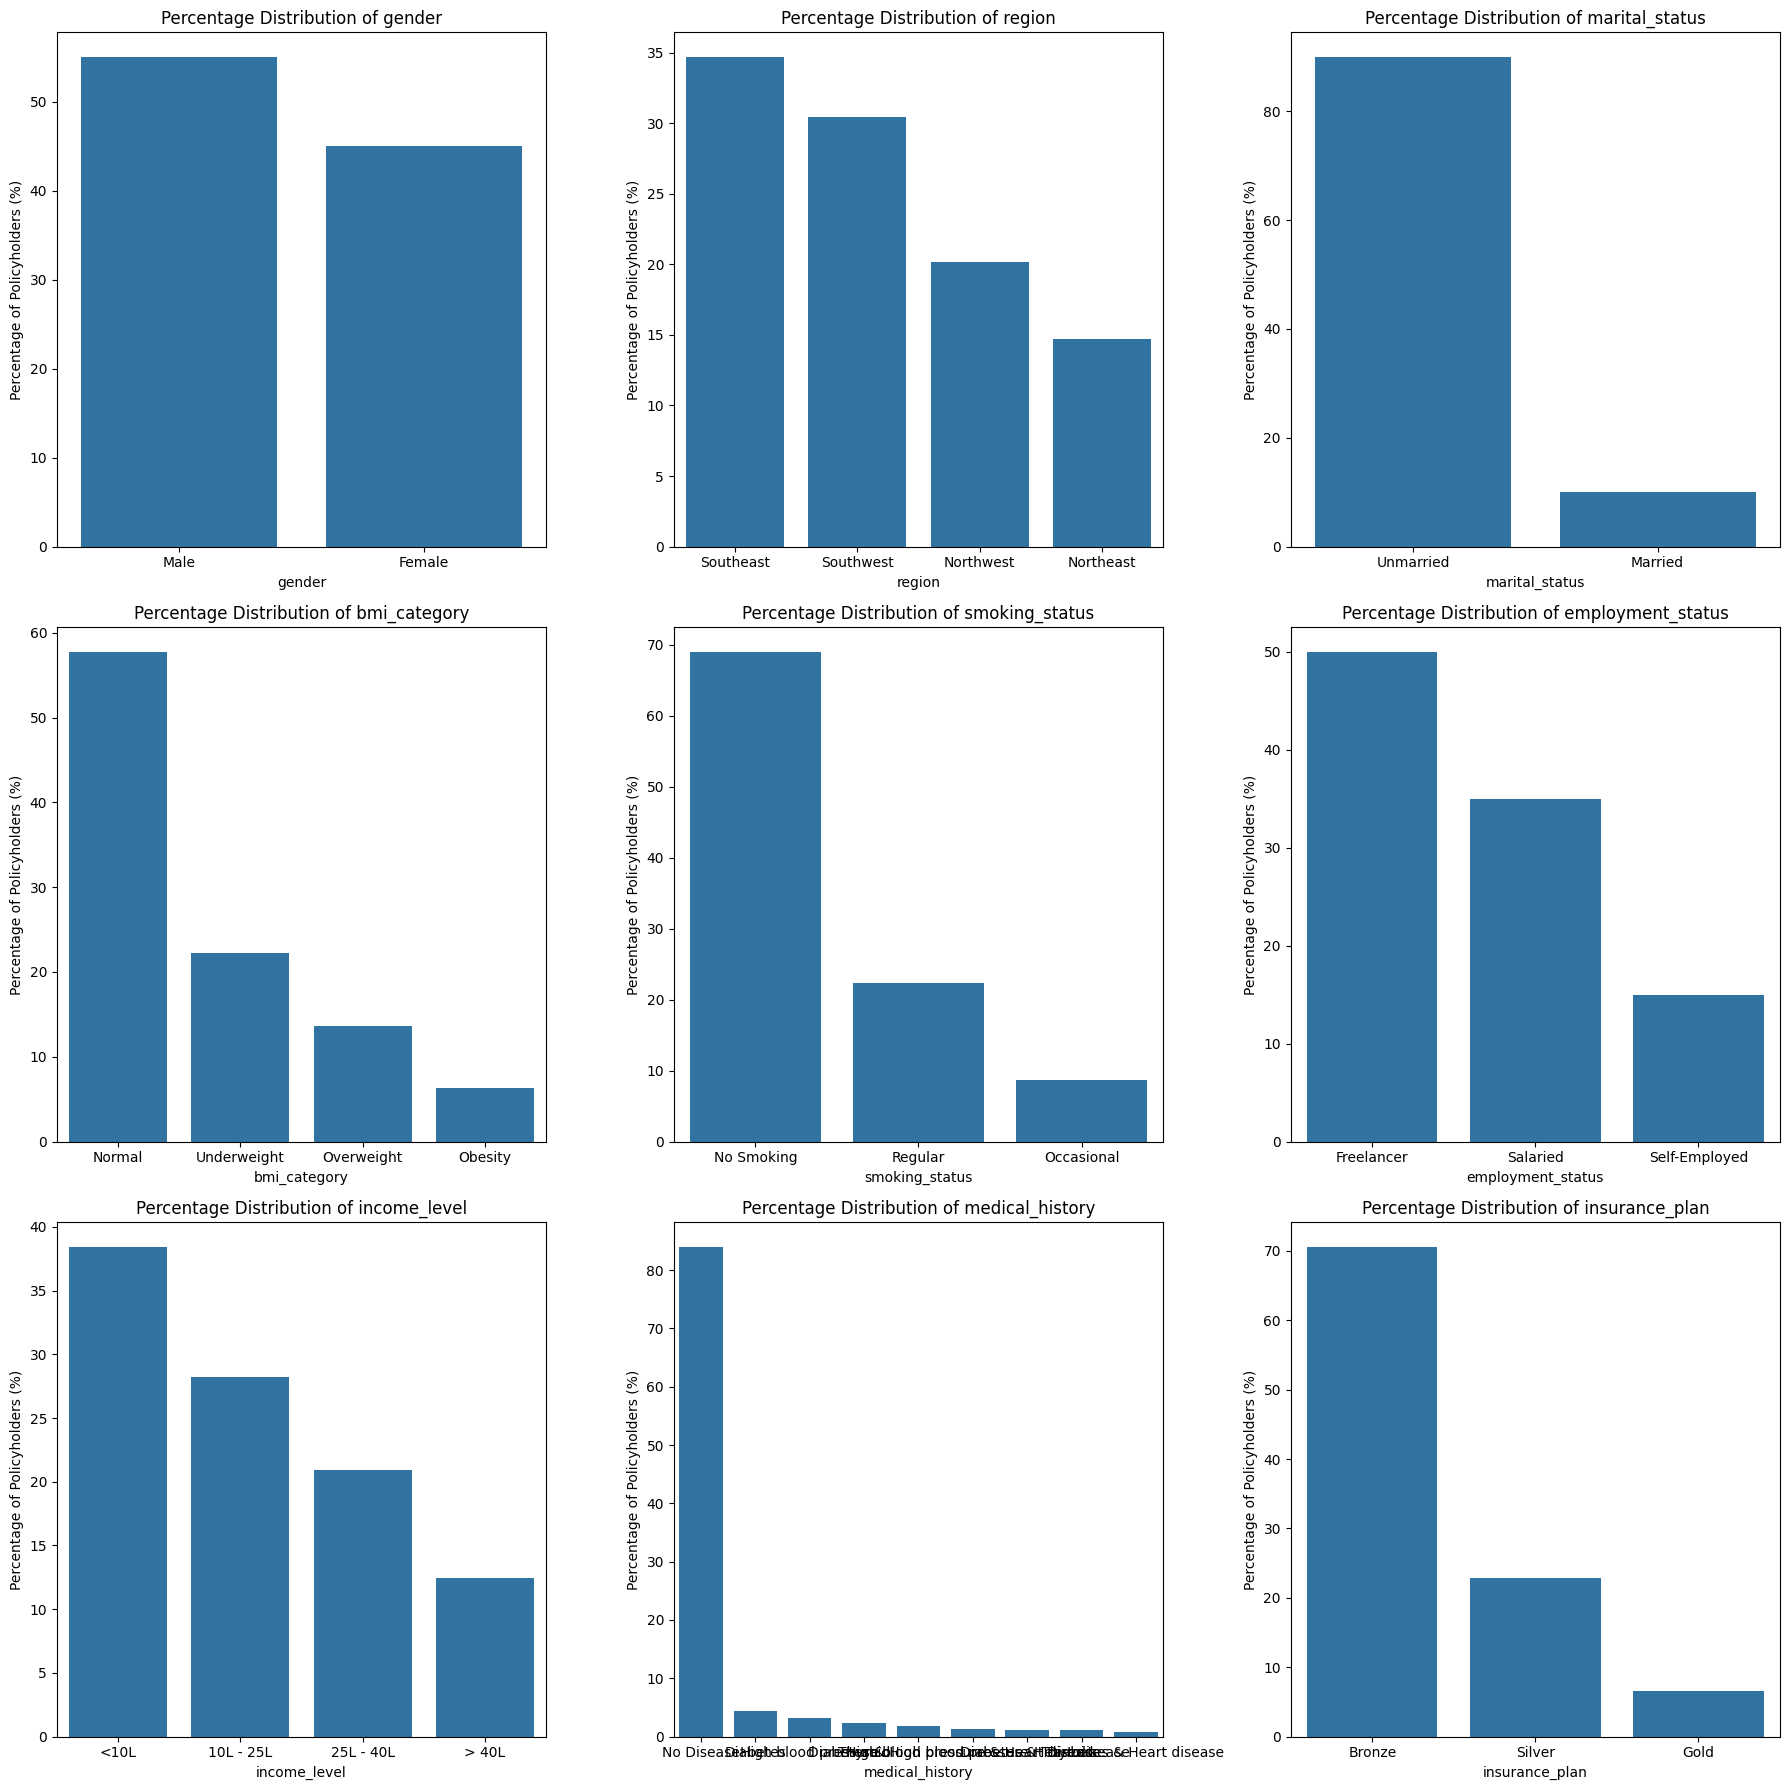

In [252]:
fig, axes = plt.subplots(3, 3, figsize=(18, 18))  # Adjust figure size as necessary
axes = axes.flatten()  # Flatten the 2D array of axes into 1D for easier iteration

for ax, column in zip(axes, categorical_cols):
    # Calculate the percentage distribution of each category
    category_counts = df2[column].value_counts(normalize=True) * 100  # normalize=True gives the relative frequencies
    
    # Plotting the distribution using barplot
    sns.barplot(x=category_counts.index, y=category_counts.values, ax=ax)
    ax.set_title(f'Percentage Distribution of {column}')
    ax.set_ylabel('Percentage of Policyholders (%)')
    ax.set_xlabel(column)  # Set xlabel to the column name for clarity

plt.tight_layout()  # Adjusts plot parameters for better fit in the figure window
plt.show()

## **Bivariate Analysis**

insurance_plan  Bronze  Gold  Silver
income_level                        
10L - 25L         4508   326     828
25L - 40L         3382   209     608
<10L              6172   404    1145
> 40L              115   366    2023


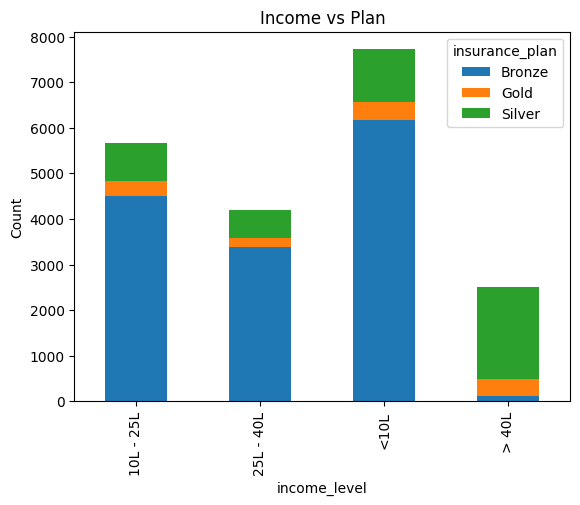

In [253]:
# Cross-tabulation of gender and smoking status
crosstab = pd.crosstab(df2['income_level'], df2['insurance_plan'])
print(crosstab)

# Plotting the crosstab
crosstab.plot(kind='bar', stacked=True)
plt.title('Income vs Plan')
plt.ylabel('Count')
plt.show()

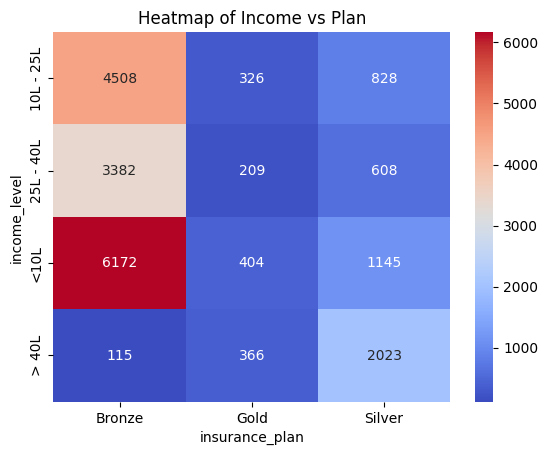

In [254]:
sns.heatmap(crosstab, annot=True, cmap='coolwarm',fmt="d")
plt.title('Heatmap of Income vs Plan')
plt.show()

<h2 align="center" style="color:blue; font-size:30px; font-weight:bold;">Feature Engineering</h2>


In [255]:
df2.head(2)

,age,gender,region,marital_status,number_of_dependants,bmi_category,smoking_status,employment_status,income_level,income_lakhs,medical_history,insurance_plan,annual_premium_amount
0,18,Male,Northeast,Unmarried,0,Overweight,Regular,Self-Employed,> 40L,99,High blood pressure,Silver,13365
1,22,Female,Northwest,Unmarried,0,Underweight,No Smoking,Freelancer,<10L,3,No Disease,Silver,11050


## **Calculate Risk Score**

In [256]:
# Define the risk scores for each condition
risk_scores = {
    "diabetes": 6,
    "heart disease": 8,
    "high blood pressure":6,
    "thyroid": 5,
    "no disease": 0,
    "none":0
}

df2[['disease1', 'disease2']] = df2['medical_history'].str.split(" & ", expand=True).apply(lambda x: x.str.lower())
df2['disease1'].fillna('none', inplace=True)
df2['disease2'].fillna('none', inplace=True)
df2['total_risk_score'] = 0

for disease in ['disease1', 'disease2']:
    df2['total_risk_score'] += df2[disease].map(risk_scores)

# Normalize the risk score to a range of 0 to 1
max_score = df2['total_risk_score'].max()
min_score = df2['total_risk_score'].min()
df2['normalized_risk_score'] = (df2['total_risk_score'] - min_score) / (max_score - min_score)
df2.head(2)

,age,gender,region,marital_status,number_of_dependants,bmi_category,smoking_status,employment_status,income_level,income_lakhs,medical_history,insurance_plan,annual_premium_amount,disease1,disease2,total_risk_score,normalized_risk_score
0,18,Male,Northeast,Unmarried,0,Overweight,Regular,Self-Employed,> 40L,99,High blood pressure,Silver,13365,high blood pressure,none,6,0.428571
1,22,Female,Northwest,Unmarried,0,Underweight,No Smoking,Freelancer,<10L,3,No Disease,Silver,11050,no disease,none,0,0.000000


## **Encode Text Columns**

In [257]:
df2['insurance_plan'] = df2['insurance_plan'].map({'Bronze': 1, 'Silver': 2, 'Gold': 3})

In [258]:
df2.income_level.unique()

array(['> 40L', '<10L', '10L - 25L', '25L - 40L'], dtype=object)

In [259]:

df2['income_level'] = df2['income_level'].map({'<10L':1, '10L - 25L': 2, '25L - 40L':3, '> 40L':4})

In [260]:
nominal_cols = ['gender', 'region', 'marital_status', 'bmi_category', 'smoking_status', 'employment_status']
df3 = pd.get_dummies(df2, columns=nominal_cols, drop_first=True, dtype=int)
df3.columns

Index(['age', 'number_of_dependants', 'income_level', 'income_lakhs',
       'medical_history', 'insurance_plan', 'annual_premium_amount',
       'disease1', 'disease2', 'total_risk_score', 'normalized_risk_score',
       'gender_Male', 'region_Northwest', 'region_Southeast',
       'region_Southwest', 'marital_status_Unmarried', 'bmi_category_Obesity',
       'bmi_category_Overweight', 'bmi_category_Underweight',
       'smoking_status_Occasional', 'smoking_status_Regular',
       'employment_status_Salaried', 'employment_status_Self-Employed'],
      dtype='object')

In [261]:
df3.info()

<class 'pandas.core.frame.DataFrame'>
Index: 20086 entries, 0 to 20095
Data columns (total 23 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   age                              20086 non-null  int64  
 1   number_of_dependants             20086 non-null  int64  
 2   income_level                     20086 non-null  int64  
 3   income_lakhs                     20086 non-null  int64  
 4   medical_history                  20086 non-null  object 
 5   insurance_plan                   20086 non-null  int64  
 6   annual_premium_amount            20086 non-null  int64  
 7   disease1                         20086 non-null  object 
 8   disease2                         20086 non-null  object 
 9   total_risk_score                 20086 non-null  int64  
 10  normalized_risk_score            20086 non-null  float64
 11  gender_Male                      20086 non-null  int64  
 12  region_Northwest       

## **Feature Selection**

In [262]:
df4 = df3.drop(['medical_history','disease1', 'disease2', 'total_risk_score'], axis=1)
df4.head(3)                

,age,number_of_dependants,income_level,income_lakhs,insurance_plan,annual_premium_amount,normalized_risk_score,gender_Male,region_Northwest,region_Southeast,region_Southwest,marital_status_Unmarried,bmi_category_Obesity,bmi_category_Overweight,bmi_category_Underweight,smoking_status_Occasional,smoking_status_Regular,employment_status_Salaried,employment_status_Self-Employed
0,18,0,4,99,2,13365,0.428571,1,0,0,0,1,0,1,0,0,1,0,1
1,22,0,1,3,2,11050,0.000000,0,1,0,0,1,0,0,1,0,0,0,0
2,21,0,4,97,2,11857,0.000000,0,0,1,0,1,0,0,0,0,1,1,0


## **Calculate VIF for Multicolinearity**

In [263]:
df4.columns

Index(['age', 'number_of_dependants', 'income_level', 'income_lakhs',
       'insurance_plan', 'annual_premium_amount', 'normalized_risk_score',
       'gender_Male', 'region_Northwest', 'region_Southeast',
       'region_Southwest', 'marital_status_Unmarried', 'bmi_category_Obesity',
       'bmi_category_Overweight', 'bmi_category_Underweight',
       'smoking_status_Occasional', 'smoking_status_Regular',
       'employment_status_Salaried', 'employment_status_Self-Employed'],
      dtype='object')

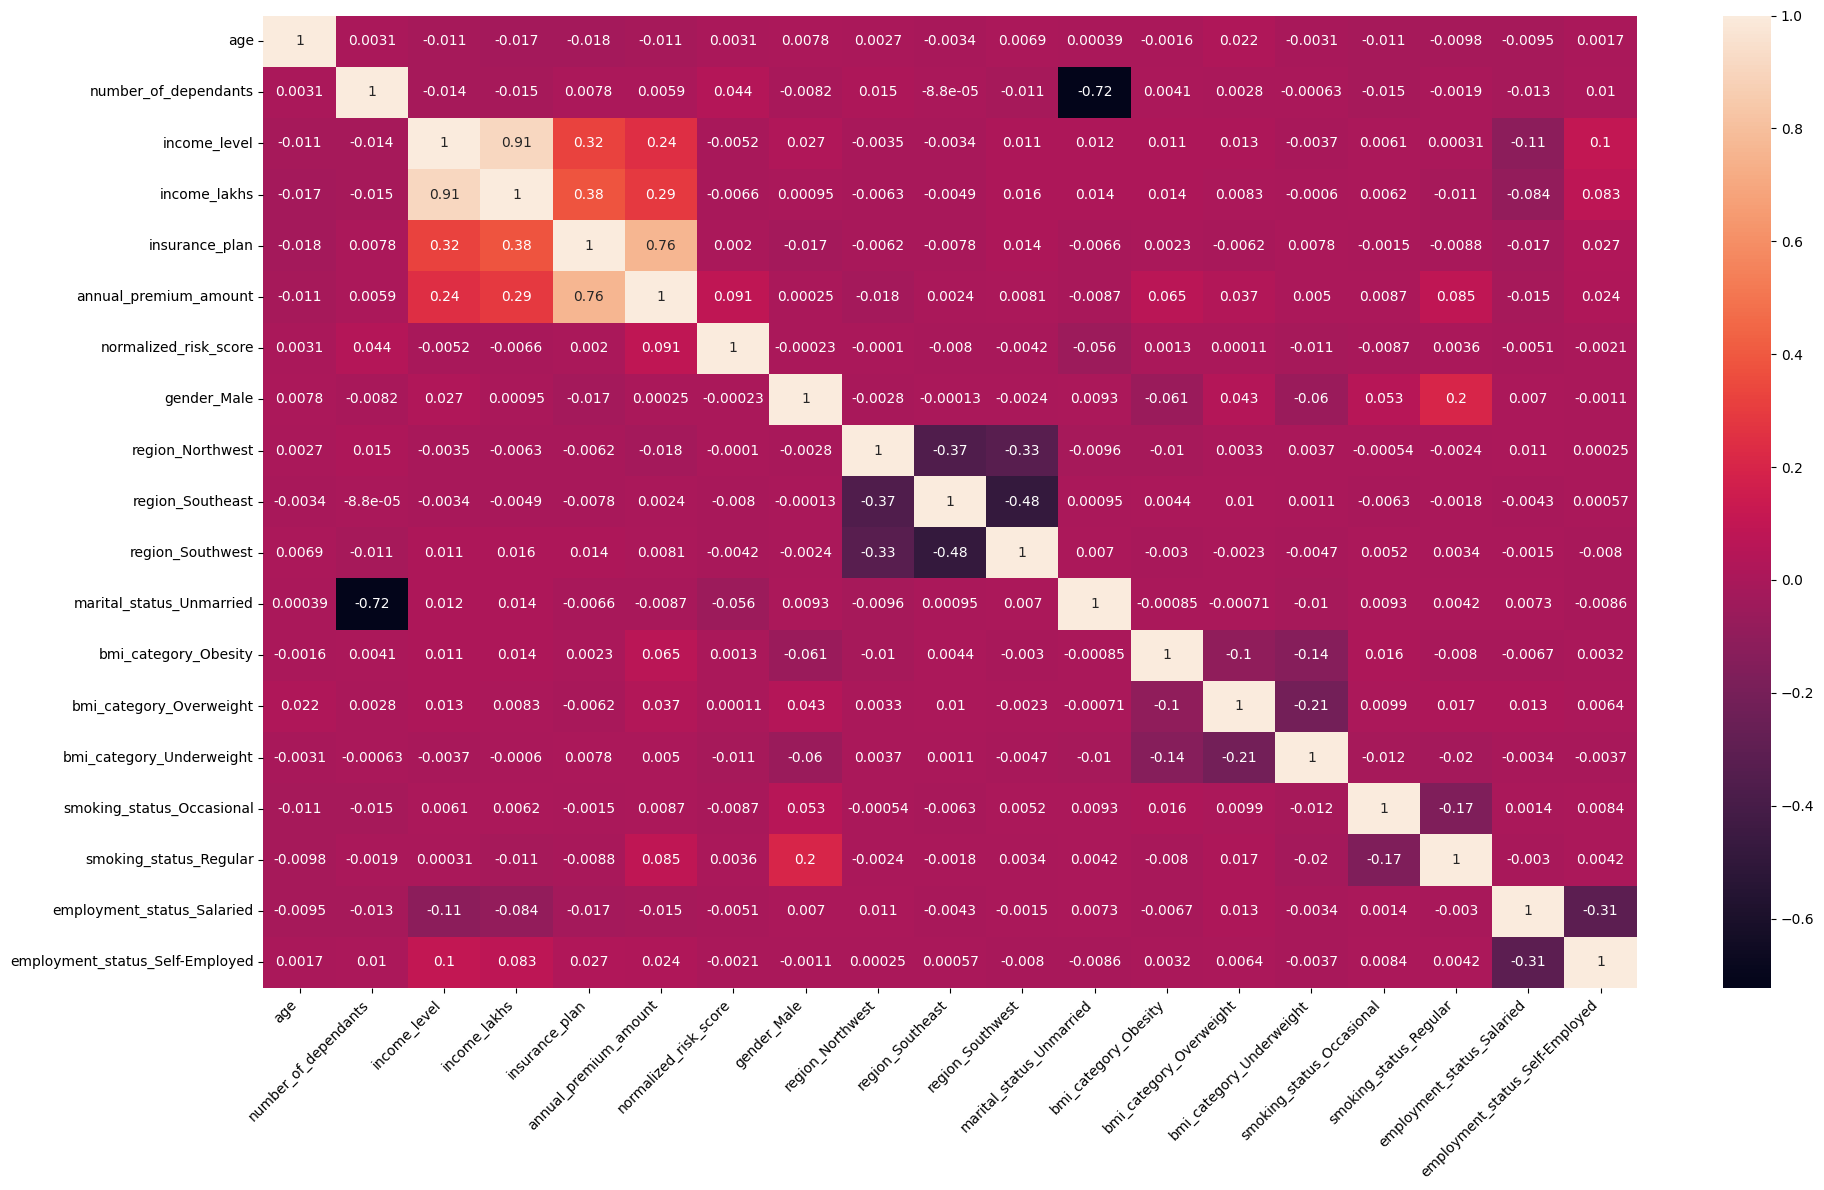

In [264]:
cm = df4.corr()

plt.figure(figsize=(20,12))
sns.heatmap(cm, annot=True)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

In [265]:
X = df4.drop('annual_premium_amount', axis='columns')
y = df4['annual_premium_amount']

from sklearn.preprocessing import MinMaxScaler

cols_to_scale = ['age','number_of_dependants', 'income_level',  'income_lakhs', 'insurance_plan']
scaler = MinMaxScaler()

X[cols_to_scale] = scaler.fit_transform(X[cols_to_scale])
X.describe()

,age,number_of_dependants,income_level,income_lakhs,insurance_plan,normalized_risk_score,gender_Male,region_Northwest,region_Southeast,region_Southwest,marital_status_Unmarried,bmi_category_Obesity,bmi_category_Overweight,bmi_category_Underweight,smoking_status_Occasional,smoking_status_Regular,employment_status_Salaried,employment_status_Self-Employed
count,20086.000000,20086.000000,20086.000000,20086.000000,20086.000000,20086.000000,20086.000000,20086.000000,20086.000000,20086.000000,20086.000000,20086.000000,20086.000000,20086.000000,20086.000000,20086.000000,20086.000000,20086.000000
mean,0.499211,0.240914,0.357994,0.216064,0.179578,0.092076,0.550383,0.201284,0.346958,0.304590,0.899881,0.063527,0.136513,0.222493,0.086379,0.223589,0.350045,0.149955
std,0.327750,0.312413,0.347481,0.219516,0.300051,0.230016,0.497467,0.400970,0.476014,0.460245,0.300167,0.243914,0.343341,0.415931,0.280929,0.416660,0.476996,0.357036
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.142857,0.000000,0.000000,0.050505,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.571429,0.000000,0.333333,0.151515,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.714286,0.333333,0.666667,0.303030,0.500000,0.000000,1.000000,0.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [266]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

def calculate_vif(data):
    vif_df = pd.DataFrame()
    vif_df['Column'] = data.columns
    vif_df['VIF'] = [variance_inflation_factor(data.values,i) for i in range(data.shape[1])]
    return vif_df

In [267]:
calculate_vif(X)

,Column,VIF
0,age,3.142881
1,number_of_dependants,1.860761
2,income_level,11.928707
3,income_lakhs,11.874242
4,insurance_plan,1.592892
5,normalized_risk_score,1.154223
6,gender_Male,2.310023
7,region_Northwest,2.147701
8,region_Southeast,2.970188
9,region_Southwest,2.730503


In [268]:
calculate_vif(X.drop('income_level', axis="columns"))

,Column,VIF
0,age,3.141534
1,number_of_dependants,1.858110
2,income_lakhs,2.291873
3,insurance_plan,1.587794
4,normalized_risk_score,1.154174
5,gender_Male,2.299848
6,region_Northwest,2.146767
7,region_Southeast,2.968993
8,region_Southwest,2.729813
9,marital_status_Unmarried,7.299818


In [269]:
# we will drop income_lakhs due to high VIF value
X_reduced = X.drop('income_level', axis="columns")

<h1 align="center" style="color:blue; font-size:30px; font-weight:bold;">Model Training</h1>


In [270]:
X_train, X_test, y_train, y_test = train_test_split(X_reduced, y, test_size=0.30, random_state=10)

# shape of the X_train, X_test, y_train, y_test features
print("x train: ",X_train.shape)
print("x test: ",X_test.shape)
print("y train: ",y_train.shape)
print("y test: ",y_test.shape)

x train:  (14060, 17)
x test:  (6026, 17)
y train:  (14060,)
y test:  (6026,)


# **Linear Regression Model**

In [271]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import numpy as np

def linear_regression_metrics(X_train, X_test, y_train, y_test):
    model = LinearRegression()
    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)

    train_r2 = model.score(X_train, y_train)
    test_r2  = model.score(X_test, y_test)
    mse      = mean_squared_error(y_test, y_pred)
    rmse     = np.sqrt(mse)

    print("Linear Regression Metrics")
    print(f"  Train R² : {train_r2:.4f}")
    print(f"  Test  R² : {test_r2:.4f}")
    print(f"  MSE      : {mse:.4f}")
    print(f"  RMSE     : {rmse:.4f}")

    return {
        "model": model,
        "train_r2": train_r2,
        "test_r2": test_r2,
        "mse": mse,
        "rmse": rmse
    }

# usage
results_lr = linear_regression_metrics(X_train, X_test, y_train, y_test)


Linear Regression Metrics
  Train R² : 0.6020
  Test  R² : 0.6048
  MSE      : 3005669.8791
  RMSE     : 1733.6868


In [272]:
X_test.shape

(6026, 17)

In [273]:
lr_model = results_lr["model"]


print(f'Coefficients: =======> {lr_model.coef_}')
print(f'Intercept: ==========> {lr_model.intercept_}')

Coefficients: =======> [ 5.51905147e+01 -1.45039643e+02 -3.60667677e+01  7.00007042e+03
  1.11127879e+03  9.82564766e+00 -1.14273450e+02 -3.64663714e+01
 -6.72232248e+01 -5.85343424e+01  7.92952660e+02  4.35760406e+02
  1.69728916e+02  2.44813937e+02  6.19082947e+02 -1.30535485e+01
 -4.34272200e+00]
Intercept: ==========> 6614.5833912307535


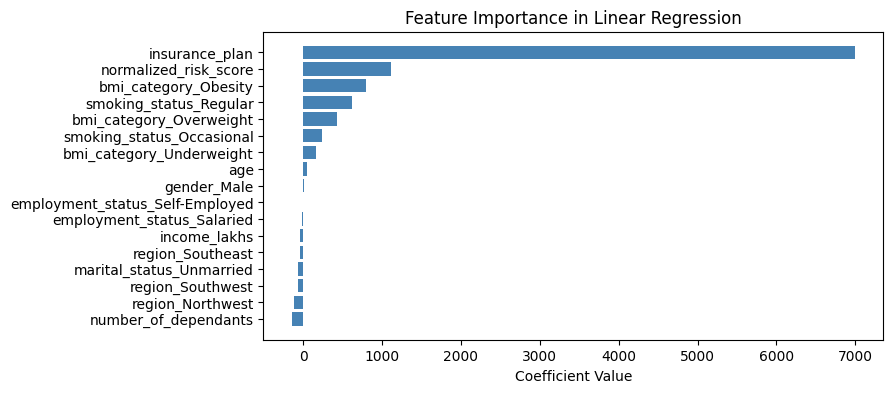

In [274]:
feature_importance = lr_model.coef_

# Create a DataFrame for easier handling
coef_df = pd.DataFrame(feature_importance, index=X_train.columns, columns=['Coefficients'])

# Sort the coefficients for better visualization
coef_df = coef_df.sort_values(by='Coefficients', ascending=True)

# Plotting
plt.figure(figsize=(8, 4))
plt.barh(coef_df.index, coef_df['Coefficients'], color='steelblue')
plt.xlabel('Coefficient Value')
plt.title('Feature Importance in Linear Regression')
plt.show()

# **Ridge Regression Model**

In [275]:
def ridge_regression_metrics(X_train, X_test, y_train, y_test, alpha=1.0):
    model_rg = Ridge(alpha=alpha)
    model_rg.fit(X_train, y_train)

    y_pred = model_rg.predict(X_test)

    train_r2 = model_rg.score(X_train, y_train)
    test_r2  = model_rg.score(X_test, y_test)
    mse_rg   = mean_squared_error(y_test, y_pred)
    rmse_rg  = np.sqrt(mse_rg)

    print(f"Ridge Regression (alpha={alpha}) Metrics")
    print(f"  Train R² : {train_r2:.4f}")
    print(f"  Test  R² : {test_r2:.4f}")
    print(f"  MSE      : {mse_rg:.4f}")
    print(f"  RMSE     : {rmse_rg:.4f}")

    return {
        "train_r2": train_r2,
        "test_r2": test_r2,
        "mse": mse_rg,
        "rmse": rmse_rg
    }

# usage
ridge_results = ridge_regression_metrics(X_train, X_test, y_train, y_test, alpha=1.0)

Ridge Regression (alpha=1.0) Metrics
  Train R² : 0.6020
  Test  R² : 0.6048
  MSE      : 3005573.9638
  RMSE     : 1733.6591


# **XGBoost** 

In [276]:
from xgboost import XGBRegressor
def xgb_regression_metrics(X_train, X_test, y_train, y_test,
                           n_estimators=20, max_depth=3, learning_rate=0.1, random_state=42):
    model_xgb = XGBRegressor(
        n_estimators=n_estimators,
        max_depth=max_depth,
        learning_rate=learning_rate,
        random_state=random_state
    )

    model_xgb.fit(X_train, y_train)

    y_pred = model_xgb.predict(X_test)

    train_r2 = model_xgb.score(X_train, y_train)
    test_r2  = model_xgb.score(X_test, y_test)
    mse_xgb  = mean_squared_error(y_test, y_pred)
    rmse_xgb = np.sqrt(mse_xgb)

    print(f"XGBoost Regression Metrics (n_estimators={n_estimators}, max_depth={max_depth})")
    print(f"  Train R² : {train_r2:.4f}")
    print(f"  Test  R² : {test_r2:.4f}")
    print(f"  MSE      : {mse_xgb:.4f}")
    print(f"  RMSE     : {rmse_xgb:.4f}")

    return {
        "train_r2": train_r2,
        "test_r2": test_r2,
        "mse": mse_xgb,
        "rmse": rmse_xgb
    }

# usage
xgb_results = xgb_regression_metrics(X_train, X_test, y_train, y_test,
                                     n_estimators=20, max_depth=3)

XGBoost Regression Metrics (n_estimators=20, max_depth=3)
  Train R² : 0.5889
  Test  R² : 0.5916
  MSE      : 3105979.2500
  RMSE     : 1762.3789


# **Hyperparameter Tuning for XGBoost using RandomizedSearchCV**

In [277]:
def xgb_random_search_metrics(X_train, X_test, y_train, y_test):
    model_xgb = XGBRegressor()

    param_grid = {
        'n_estimators': [20, 40, 50],
        'learning_rate': [0.01, 0.1, 0.2],
        'max_depth': [3, 4, 5],
    }

    random_search = RandomizedSearchCV(
        estimator=model_xgb,
        param_distributions=param_grid,
        n_iter=10,
        cv=3,
        scoring='r2',
        random_state=42,
        n_jobs=1
    )

    random_search.fit(X_train, y_train)

    best_model = random_search.best_estimator_

    # Train/Test scores & metrics with best model
    train_r2 = best_model.score(X_train, y_train)
    test_r2  = best_model.score(X_test, y_test)

    y_pred = best_model.predict(X_test)
    mse    = mean_squared_error(y_test, y_pred)
    rmse   = np.sqrt(mse)

    print("Best Params:", random_search.best_params_)
    print(f"CV Best R² : {random_search.best_score_:.4f}")
    print("XGBoost (Best Model) Test Metrics:")
    print(f"  Train R² : {train_r2:.4f}")
    print(f"  Test  R² : {test_r2:.4f}")
    print(f"  MSE      : {mse:.4f}")
    print(f"  RMSE     : {rmse:.4f}")

    return best_model, random_search

# usage
best_xgb_model, xgb_search = xgb_random_search_metrics(X_train, X_test, y_train, y_test)

Best Params: {'n_estimators': 50, 'max_depth': 3, 'learning_rate': 0.1}
CV Best R² : 0.5997
XGBoost (Best Model) Test Metrics:
  Train R² : 0.6040
  Test  R² : 0.6037
  MSE      : 3014080.2500
  RMSE     : 1736.1107


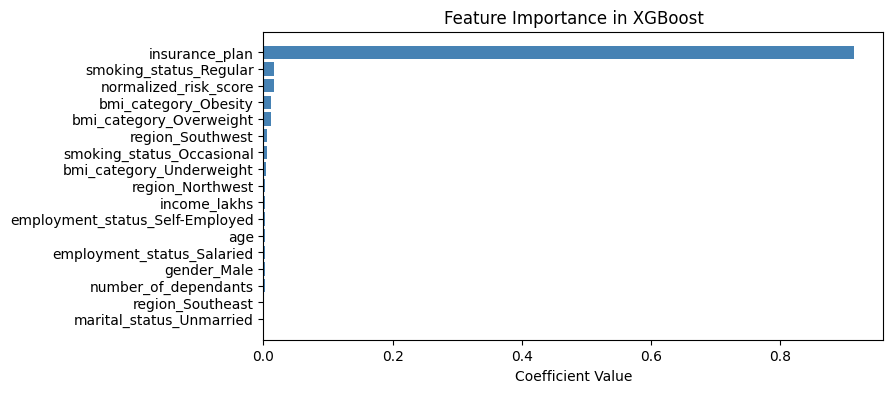

In [278]:
feature_importance = best_xgb_model.feature_importances_

# Create a DataFrame for easier handling
coef_df = pd.DataFrame(feature_importance, index=X_train.columns, columns=['Coefficients'])

# Sort the coefficients for better visualization
coef_df = coef_df.sort_values(by='Coefficients', ascending=True)

# Plotting
plt.figure(figsize=(8, 4))
plt.barh(coef_df.index, coef_df['Coefficients'], color='steelblue')
plt.xlabel('Coefficient Value')
plt.title('Feature Importance in XGBoost')
plt.show()

In [279]:
y_pred = best_xgb_model.predict(X_test)

residuals = y_pred - y_test
residuals_pct = (residuals / y_test) * 100

results_df = pd.DataFrame({
    'actual': y_test, 
    'predicted': y_pred, 
    'diff': residuals, 
    'diff_pct': residuals_pct
})
results_df.head()

,actual,predicted,diff,diff_pct
12774,6238,6669.329590,431.329590,6.914549
14758,9462,6999.429199,-2462.570801,-26.025902
13205,5152,6998.085449,1846.085449,35.832404
14278,6988,7868.310059,880.310059,12.597454
19351,4917,6677.658203,1760.658203,35.807570


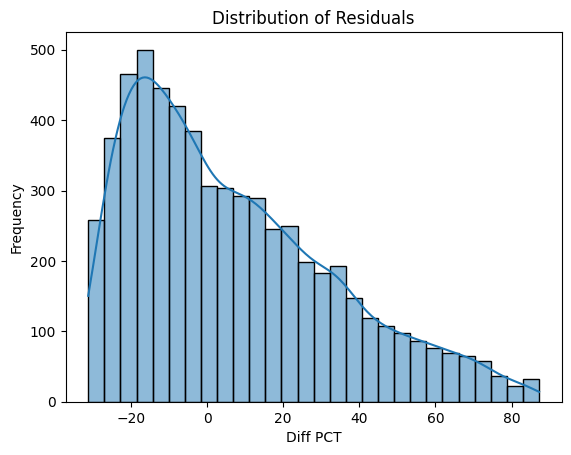

In [280]:
sns.histplot(results_df['diff_pct'], kde=True)
plt.title('Distribution of Residuals')
plt.xlabel('Diff PCT')
plt.ylabel('Frequency')
plt.show()

In [281]:
X_test.shape

(6026, 17)

In [282]:
extreme_error_threshold = 10  # this threshold based on your requirements

In [283]:

# for extreme errors: |diff_pct| >= 10
extreme_mask = results_df['diff_pct'].abs() >= extreme_error_threshold

# DataFrame with only extreme-error customers
extreme_results_df = results_df[extreme_mask]

# Percentage of extreme-error customers
extreme_errors_pct = extreme_results_df.shape[0] * 100 / results_df.shape[0]
print(f"Customers with >= {extreme_error_threshold}% , error: {extreme_errors_pct:.2f}%")

# Seeing worst extreme errors (sorted by percentage difference)
extreme_results_df_sorted = extreme_results_df[abs(extreme_results_df.diff_pct)>10].sort_values("diff_pct", ascending=False)
extreme_results_df_sorted


Customers with >= 10% , error: 73.13%


,actual,predicted,diff,diff_pct
4169,3517,6584.604004,3067.604004,87.222178
4692,3516,6572.262207,3056.262207,86.924409
12285,3532,6585.947754,3053.947754,86.465112
3652,3536,6585.947754,3049.947754,86.254179
16580,3538,6585.947754,3047.947754,86.148891
...,...,...,...,...
7038,9484,6585.947754,-2898.052246,-30.557278
530,9487,6585.947754,-2901.052246,-30.579237
696,9491,6585.947754,-2905.052246,-30.608495
16059,9317,6445.819336,-2871.180664,-30.816579


In [284]:
extreme_results_df_sorted.shape

(4407, 4)

##### **I have 73% extreme errors which means for 73% customers will either overcharge or undercharge by 10% or more on Younger Adults Less than 25**

In [285]:
extreme_errors_pct = extreme_results_df.shape[0]*100/X_test.shape[0]
extreme_errors_pct

73.13308994357783

In [286]:
extreme_results_df[abs(extreme_results_df.diff_pct)>10].sort_values("diff_pct",ascending=False)

,actual,predicted,diff,diff_pct
4169,3517,6584.604004,3067.604004,87.222178
4692,3516,6572.262207,3056.262207,86.924409
12285,3532,6585.947754,3053.947754,86.465112
3652,3536,6585.947754,3049.947754,86.254179
16580,3538,6585.947754,3047.947754,86.148891
...,...,...,...,...
7038,9484,6585.947754,-2898.052246,-30.557278
530,9487,6585.947754,-2901.052246,-30.579237
696,9491,6585.947754,-2905.052246,-30.608495
16059,9317,6445.819336,-2871.180664,-30.816579


##### **There were about 4407 customers whom premium plan may overcharged or undercharged by more than 10%.**

In [287]:
extreme_errors_df = X_test.loc[extreme_results_df.index]
extreme_errors_df.head(2)

,age,number_of_dependants,income_lakhs,insurance_plan,normalized_risk_score,gender_Male,region_Northwest,region_Southeast,region_Southwest,marital_status_Unmarried,bmi_category_Obesity,bmi_category_Overweight,bmi_category_Underweight,smoking_status_Occasional,smoking_status_Regular,employment_status_Salaried,employment_status_Self-Employed
14758,0.285714,0.000000,0.060606,0.0,0.0,0,0,0,1,1,0,0,0,0,1,0,1
13205,0.714286,0.333333,0.141414,0.0,0.0,1,1,0,0,1,0,0,0,0,1,0,1


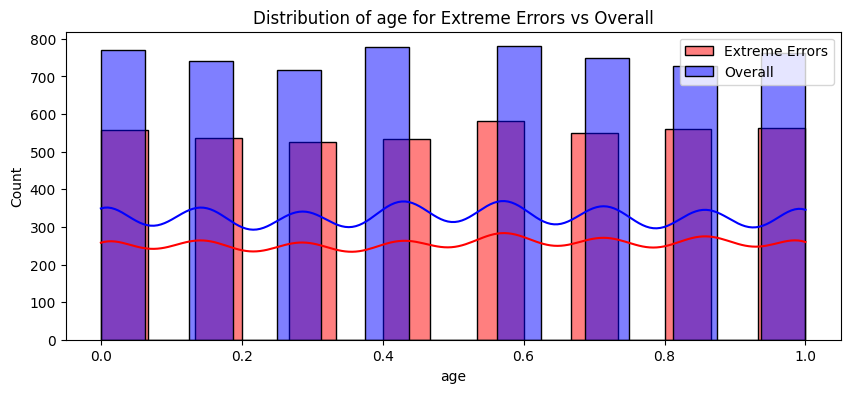

<Figure size 640x480 with 0 Axes>

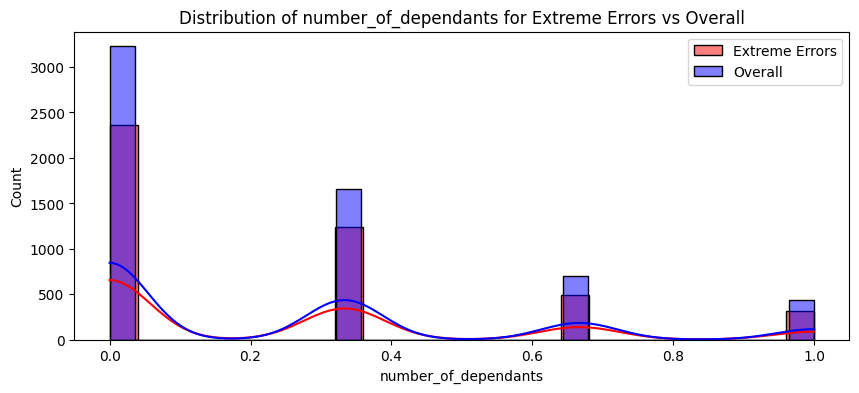

<Figure size 640x480 with 0 Axes>

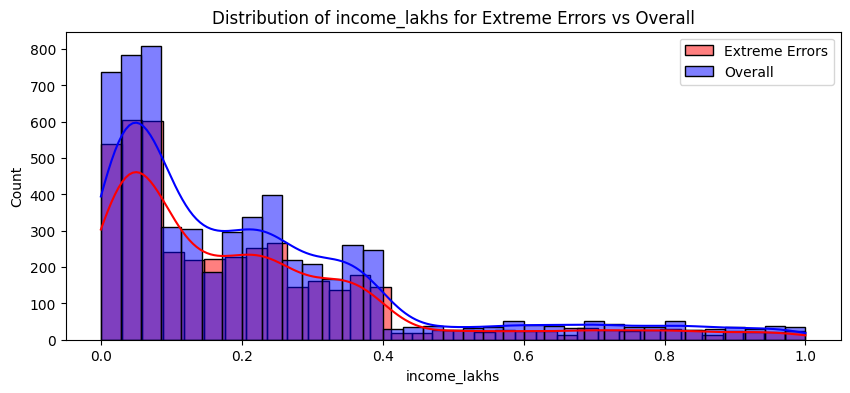

<Figure size 640x480 with 0 Axes>

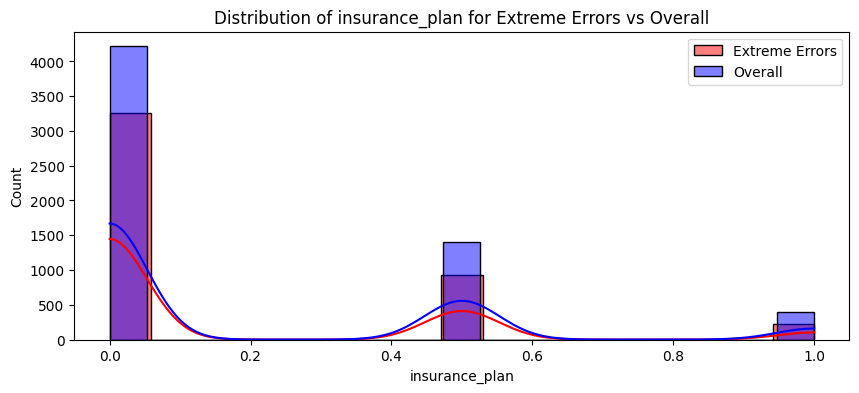

<Figure size 640x480 with 0 Axes>

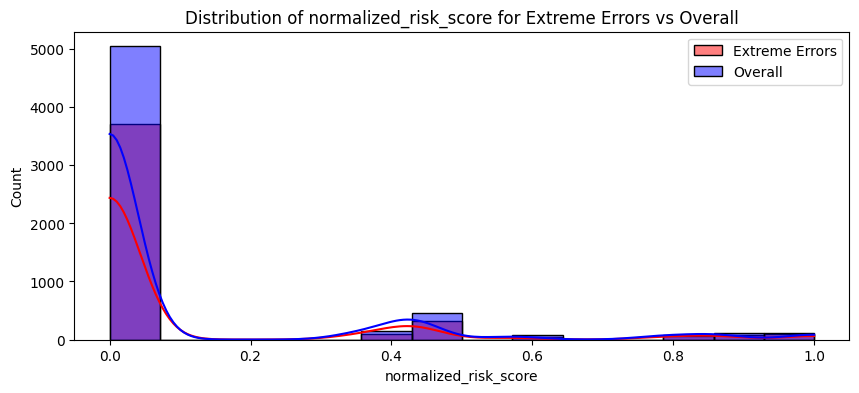

<Figure size 640x480 with 0 Axes>

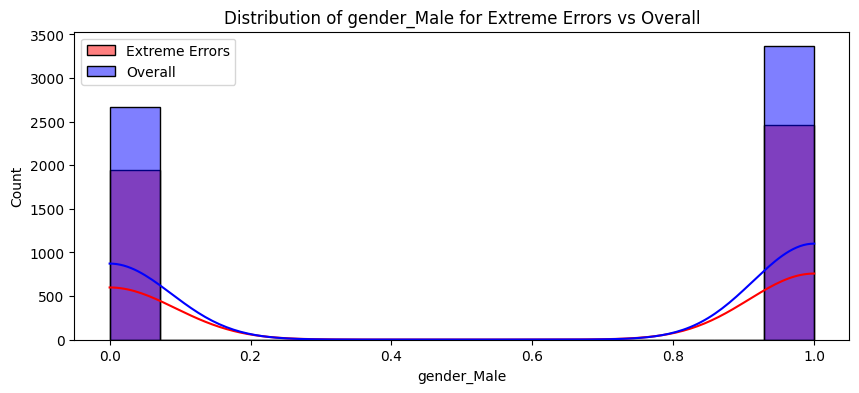

<Figure size 640x480 with 0 Axes>

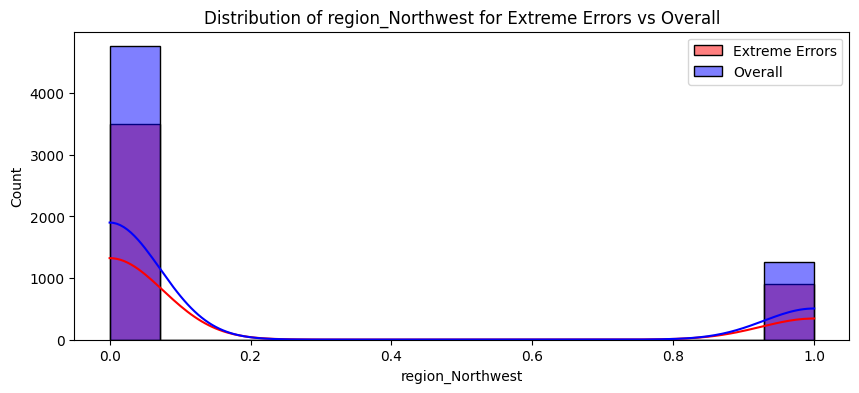

<Figure size 640x480 with 0 Axes>

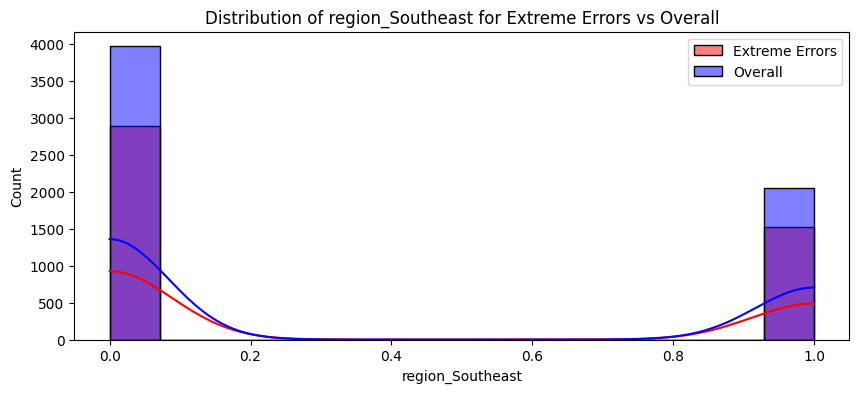

<Figure size 640x480 with 0 Axes>

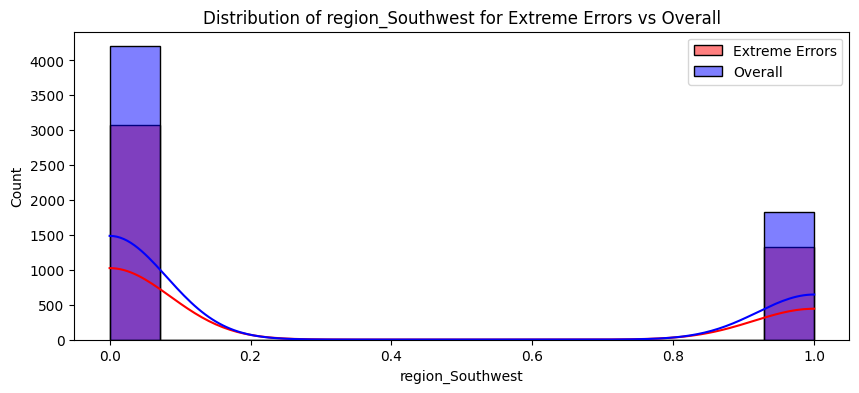

<Figure size 640x480 with 0 Axes>

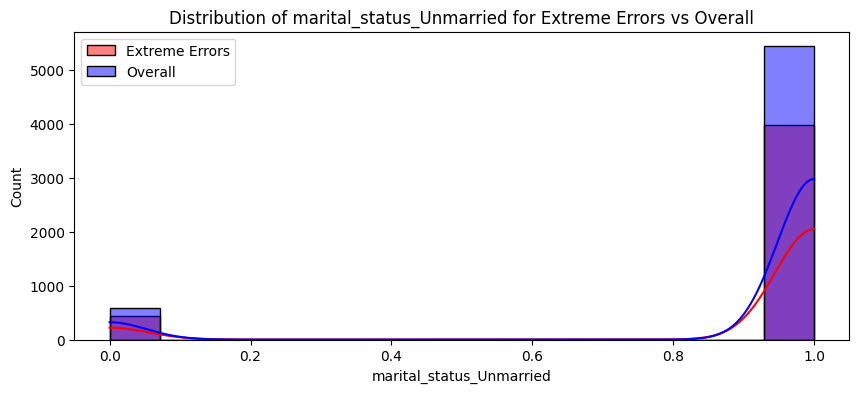

<Figure size 640x480 with 0 Axes>

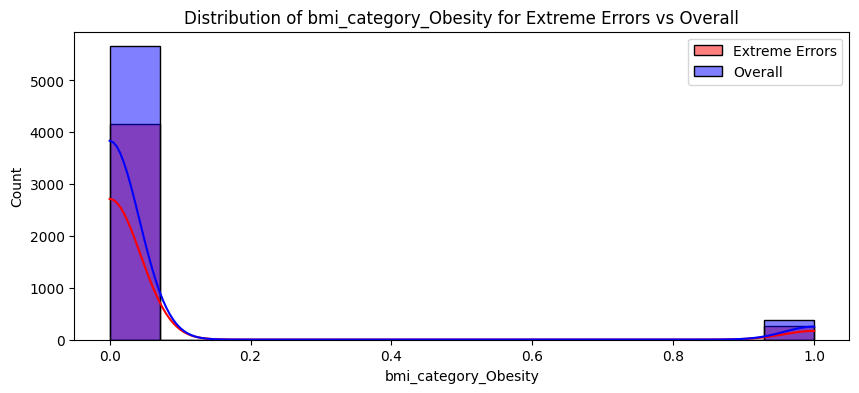

<Figure size 640x480 with 0 Axes>

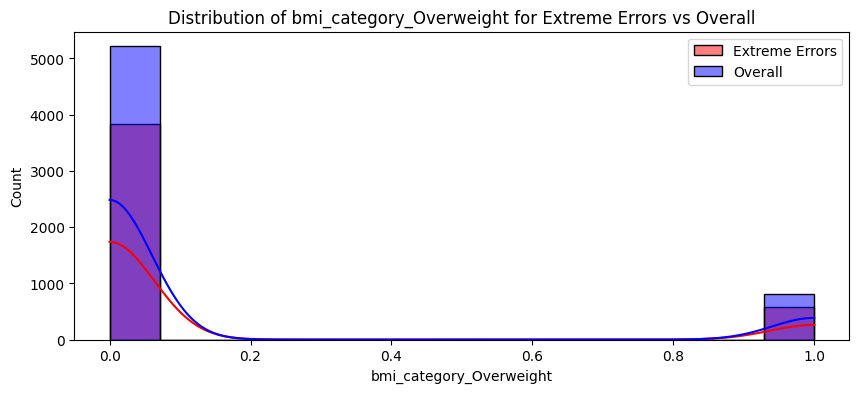

<Figure size 640x480 with 0 Axes>

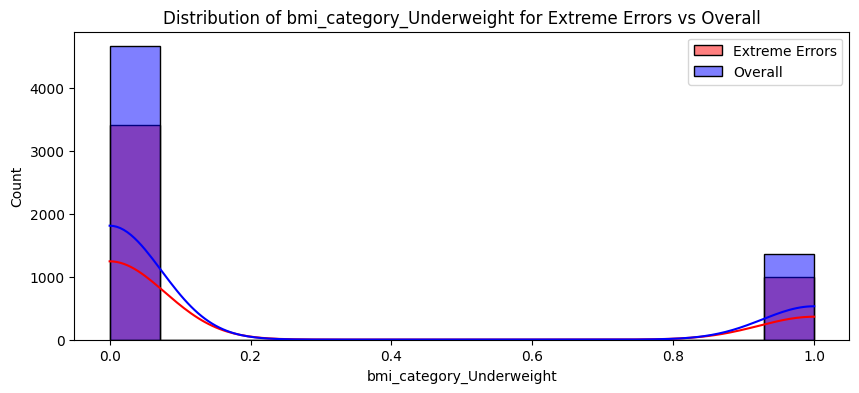

<Figure size 640x480 with 0 Axes>

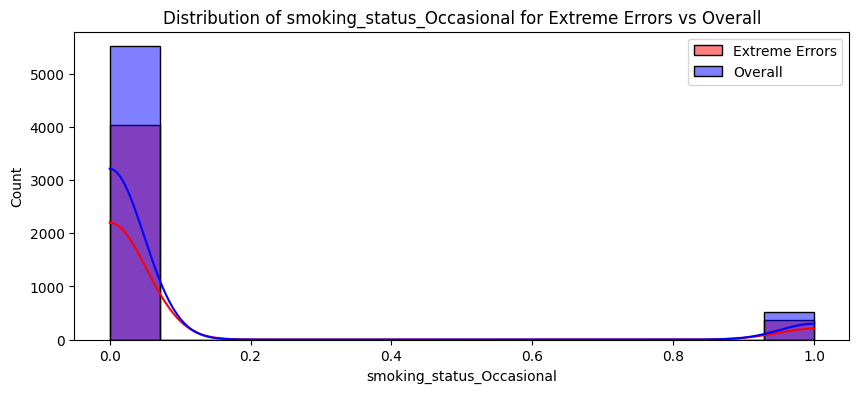

<Figure size 640x480 with 0 Axes>

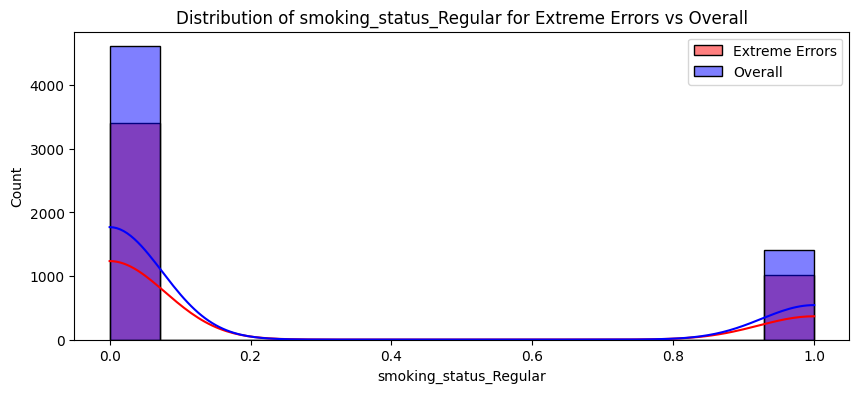

<Figure size 640x480 with 0 Axes>

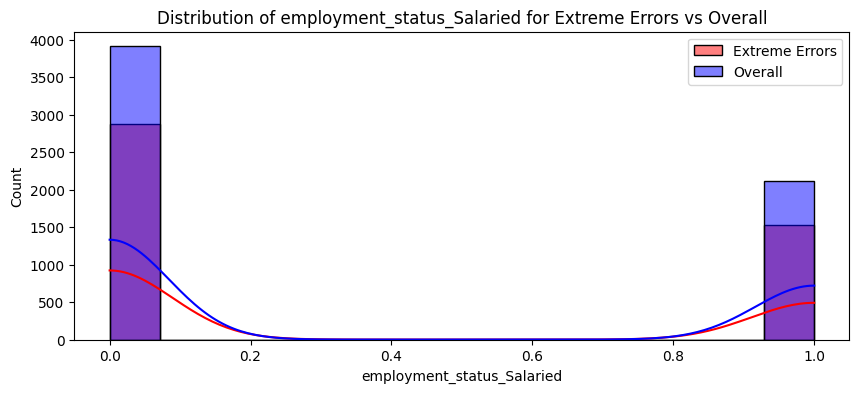

<Figure size 640x480 with 0 Axes>

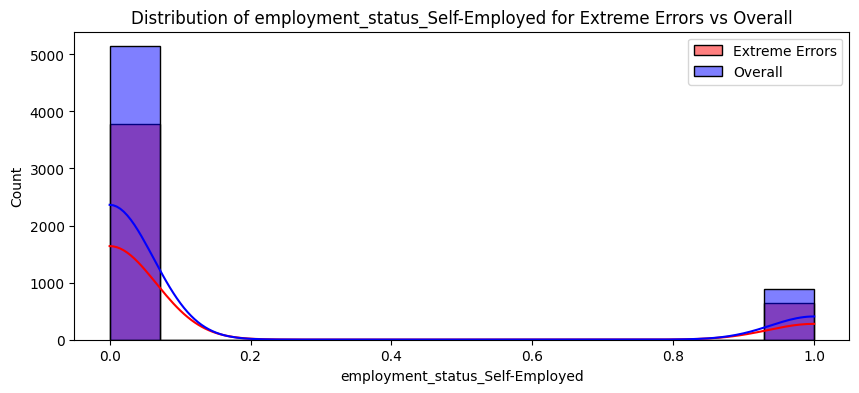

<Figure size 640x480 with 0 Axes>

In [288]:
for feature in X_test.columns:
    plt.figure(figsize=(10, 4))
    sns.histplot(extreme_errors_df[feature], color='red', label='Extreme Errors', kde=True)
    sns.histplot(X_test[feature], color='blue', label='Overall', alpha=0.5, kde=True)
    plt.legend()
    plt.title(f'Distribution of {feature} for Extreme Errors vs Overall')
    plt.show()
    plt.savefig('Distribution of Extreme Errors.png')

#  **Reverse Scaling**

In [289]:
extreme_errors_df['income_level']=-1

In [290]:
df_reversed = pd.DataFrame()
df_reversed[cols_to_scale] = scaler.inverse_transform(extreme_errors_df[cols_to_scale])
df_reversed.head()

,age,number_of_dependants,income_level,income_lakhs,insurance_plan
0,20.0,0.0,-2.0,7.0,1.0
1,23.0,1.0,-2.0,15.0,1.0
2,23.0,1.0,-2.0,23.0,1.0
3,22.0,0.0,-2.0,11.0,1.0
4,21.0,1.0,-2.0,6.0,1.0


In [291]:
df_reversed.describe()

,age,number_of_dependants,income_level,income_lakhs,insurance_plan
count,4407.000000,4407.000000,4407.0,4407.000000,4407.000000
mean,21.529158,0.719083,-2.0,21.531881,1.313592
std,2.298631,0.925042,0.0,20.973262,0.565424
min,18.000000,0.000000,-2.0,1.000000,1.000000
25%,20.000000,0.000000,-2.0,6.000000,1.000000
50%,22.000000,0.000000,-2.0,15.000000,1.000000
75%,24.000000,1.000000,-2.0,30.000000,2.000000
max,25.000000,3.000000,-2.0,100.000000,3.000000


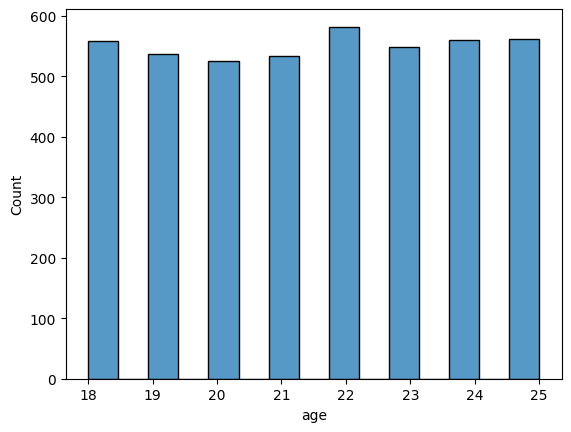

In [292]:
sns.histplot(df_reversed.age)
plt.savefig('age_error.png')

##### **This showed that the majority of the extreme errors came from the young age group (i.e., under 25 years old). so Im Decided to Request the Client for More data. So i got new data set based upon Genetical Factor for younger age**